In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from MITgcmutils import mds
from tqdm import tqdm
from jmd95 import eos
import datetime
import os

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


bmap = brewer2mpl.get_map('Set1', 'Qualitative', 6)
plt.rcParams['axes.color_cycle'] = bmap.mpl_colors


/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#ddir = '/glade/scratch/rpa/SOSE/run_matt'
#ddir = '/data/scratch/rpa/SOSE/run_matt'
ddir = '/data/scratch/rpa/SOSE/run_np240'

m = MITgcmmodel.ModelInstance(output_dir=ddir)


2160 320  42


/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)



    frequency(1) =  432000.0,
    fields(1,1) = 'SIarea  ','SIheff  ','SIhsnow ','SItflux ',
                 'SIatmQnt','SIempmr ','SIatmFW ','SIuheff ',
                 'SIvheff ','TFLUX   ','SFLUX   ','THETA   ',
                 'SALT    ','WTHMASS ','WSLTMASS','SIuice  ',
                 'SIvice  ','SIsnPrcp',
                 'SIdHbOCN','SIdSbOCN','SIdHbATO',
    levels(1,1) = 1,
    filename(1) = 'DiagIce-5day',


In [3]:
deltaT = 900
#diag_freq = 2629200. # monthly
#diag_prefix = 'DiagIce-monthly'

diag_freq = 432000 # 5-day
diag_prefix= 'DiagIce-5day'

diag_delta_iter = diag_freq/deltaT

ntimesteps = 210336
diag_iters = np.round(np.arange(diag_delta_iter, ntimesteps+1, diag_delta_iter)).astype('i4')
Nt = len(diag_iters)

diag_names = ['SIarea', 'SIheff', 'SIhsnow', 'SItflux', 'SIatmQnt', 'SIempmr',
             'SIatmFW', 'SIuheff', 'SIvheff', 'TFLUX', 'SFLUX', 'THETA', 'SALT',
             'WTHMASS','WSLTMASS','SIuice','SIvice','SIsnPrcp',
             'SIdHbOCN','SIdSbOCN','SIdHbATO']



In [4]:
Nt

438

In [5]:
lon = m.xc[0,:,:]
lat = m.yc[0,:,:]

In [6]:
def surface_transformation_rate(m, rho, rholevs, *args):
    """Calculate surface transformation rate given
        m: an MITgcmmodel.ModelInstance
        rho: a surface density field
        rholevs: density levels (to define bins)
        args: various components of the density flux
    """

    drho = np.diff(rholevs)
    Nbins = len(rholevs)-1
    
    # mask anything outside the range
    rho_m = np.ma.masked_greater_equal(
                np.ma.masked_less(rho, rholevs.min()), rholevs.max())
    mask = rho_m.mask
    
    rho_idx = np.digitize(rho_m.compressed(), rholevs)-1
    assert rho_idx.min()>=0
    assert rho_idx.max()<=Nbins
        
    # rho_idx==i means rholevs[i-1] <= rholevs < rholevs[i]
    
    
    res = []
    for a in args:
        dens_flux = np.ma.masked_array(a * m.rac, mask)
        res.append(
            np.bincount(rho_idx, weights=dens_flux.compressed(), minlength=Nbins)
            / drho
        )
    return np.array(res)
    
    

In [6]:
def average_field_in_rho(m, rho, rholevs, a, avg=True):
    """Calculate surface transformation rate given
        m: an MITgcmmodel.ModelInstance
        rho: a surface density field
        rholevs: density levels (to define bins)
        args: various components of the density flux
    """

    drho = np.diff(rholevs)
    Nbins = len(rholevs)-1
    
    # mask anything outside the range
    rho_m = np.ma.masked_greater_equal(
                np.ma.masked_less(rho, rholevs.min()), rholevs.max())
    mask = rho_m.mask
    
    rho_idx = np.digitize(rho_m.compressed(), rholevs)-1
    assert rho_idx.min()>=0
    assert rho_idx.max()<=Nbins
        
    # rho_idx==i means rholevs[i-1] <= rholevs < rholevs[i]
    
        
    rac_masked = np.ma.masked_array(m.rac, mask)
    area = np.bincount(rho_idx, weights=rac_masked.compressed(), minlength=Nbins)
    area_recip = np.where(area>0., area**-1, 0.)

    # area-weighted average
    res = np.bincount(rho_idx, weights=(a*rac_masked).compressed(), minlength=Nbins)
    if avg:
        res *= area_recip
    return res, area
    

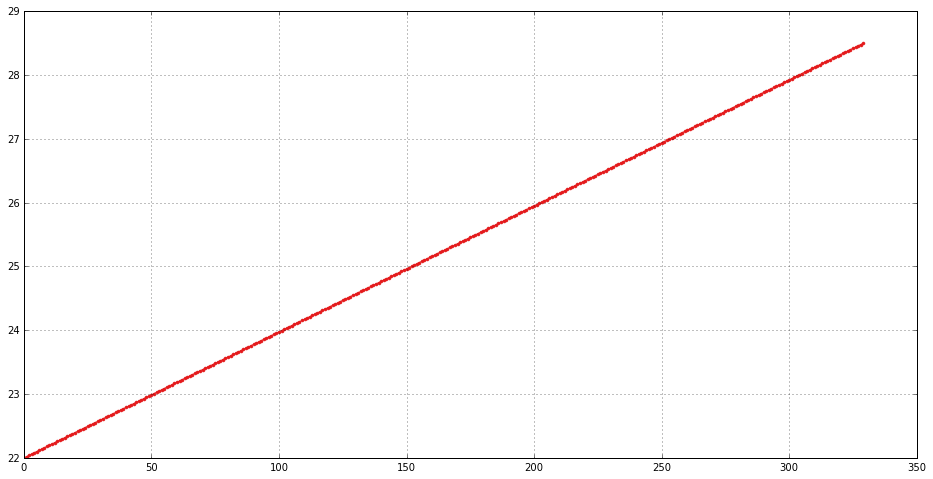

In [28]:
gam_levs = np.linspace(22,28.5,330)
# nothing about 28.5
#gam_levs = np.linspace(22,28.7,330)
Nrho2 = len(gam_levs)
drho = np.diff(gam_levs)
rholevs = gam_levs

plt.plot(gam_levs, '.-')
plt.grid()

In [8]:
salt_EvPrRn=0.
rUnit2mass=1.035E+03
HeatCapacity_Cp=3.994E+03

fluxfac_T = 1.0/(HeatCapacity_Cp*rUnit2mass)
fluxfac_S = 1.0/rUnit2mass

# gives m/year
scalefac = 24*60*60*365/1e3

#Nrho = 300
#rholevs = np.linspace(1022.,1028.0,Nrho+1)

Nrho = len(rholevs)-1

kg_fw_to_m = 1e-3
m_to_kg_fw = 1e3

fw_flux_types = ['IO_plus_AO', 'AI_plus_AO', 'AI', 'AO', 'IO', 'IO_brine', 'IO_melt']

fld_idx = dict()
for n, k in enumerate(fw_flux_types):
    fld_idx[k] = n


In [9]:
nrec = 0
new_ddir = '/data/scratch/rpa/SOSE/matt_iter100'

In [10]:
b_fac = np.load('b_factor.npy')
print b_fac.shape

(42, 320, 2160)


In [16]:
transformation = np.zeros((Nt, len(fw_flux_types)+3, Nrho), 'f8')
fw_in_dens_coords = np.zeros((Nt, len(fw_flux_types), Nrho), 'f8')

for nmon, niter in tqdm(enumerate(diag_iters)):
    
    draw = m.rdmds(diag_prefix, niter)
    d = {}
    for n, dn in enumerate(diag_names):
        d[dn] = draw[n]
    
    # load pre-computed neutral density
    gamma = mds.rdmds(os.path.join(new_ddir, 'GAMMA.0000000100'), rec=nmon, lev=0)
    gamma = np.ma.masked_less(gamma,20)

    # use surface referenced alpha and beta
    #rho, drhodt, drhods = eos.state(pref, d['THETA'], d['SALT'])
    _, drhodt, drhods = eos.state_surface(d['THETA'], d['SALT'])
    # multiply by neutral density b factor
    drhodt *= b_fac[0]
    drhods *= b_fac[0]
    
    # freshwater fluxes, evaporation positive
    fw_fluxes = {
      'IO_plus_AO': np.ma.masked_array(d['SIempmr'], m.mask[0]),
      'AI_plus_AO': -np.ma.masked_array(d['SIatmFW'], m.mask[0]),
# ------ not actually useful ----------
#       'SIdHbOCN': -m_to_kg_fw * np.ma.masked_array(data['SIdHbOCN'][season], m.mask[0]),
#       'SIdSbOCN': -m_to_kg_fw * np.ma.masked_array(data['SIdSbOCN'][season], m.mask[0]),
#       'SIdHbATO': -m_to_kg_fw * np.ma.masked_array(data['SIdSbOCN'][season], m.mask[0]),
      'SIsnPrcp':  -np.ma.masked_array(d['SIsnPrcp'], m.mask[0])
    }
    
    fw_fluxes['AI'] = fw_fluxes['SIsnPrcp']
    fw_fluxes['AO'] = fw_fluxes['AI_plus_AO'] - fw_fluxes['AI']
    fw_fluxes['IO'] = fw_fluxes['IO_plus_AO'] - fw_fluxes['AO']
    # brine rejection
    fw_fluxes['IO_brine'] = np.ma.masked_less(fw_fluxes['IO'].copy(), 0.)
    fw_fluxes['IO_melt'] = np.ma.masked_greater(fw_fluxes['IO'].copy(), 0.)
    
    # has the same units as SFLUX
    salt = d['SALT']
    
    dens_flux_S = [ drhods * fluxfac_S * fw_fluxes[k].filled(0.) * (salt - salt_EvPrRn)
                    for k in fw_flux_types ]

    dens_flux_S.append( drhods * d['WSLTMASS'] )
    
    fw_flux = [fw_fluxes[k].filled(0.) for k in fw_flux_types]
    
    tflux = np.ma.masked_array(d['TFLUX'], m.mask[0]) 
    dens_flux_T = [drhodt * fluxfac_T * tflux, ]
    
    dens_flux_T.append( drhodt * d['WTHMASS'])
    
    transformation[nmon] = surface_transformation_rate(
                        m, gamma, rholevs,
                         *(dens_flux_T + dens_flux_S))
    
    fw_in_dens_coords[nmon] = surface_transformation_rate(
                        m, gamma, rholevs, *fw_flux)

    

In [15]:
nmon

386

In [52]:
# density-weighted ice concentration
ice_conc_rho = np.zeros((Nt, Nrho), 'f8')
heff_rho = np.zeros((Nt, Nrho), 'f8')
outcrop_area = np.zeros((Nt, Nrho), 'f8')
for nmon, niter in tqdm(enumerate(diag_iters)):
    
    SIarea = m.rdmds(diag_prefix, niter, rec=0)
    heff = m.rdmds(diag_prefix, niter, rec=1)
    theta = m.rdmds(diag_prefix, niter, rec=11)
    salt = m.rdmds(diag_prefix, niter, rec=12)
    
    # load pre-computed neutral density
    rho = mds.rdmds(os.path.join(new_ddir, 'GAMMA.0000000100'), rec=nmon, lev=0)
    rho = np.ma.masked_less(rho,20)
    
    ice_conc_rho[nmon], outcrop_area[nmon] = average_field_in_rho(m, rho, rholevs, SIarea)
    heff_rho[nmon], outcrop_area[nmon] = average_field_in_rho(m, rho, rholevs, heff, avg=False)
    

In [14]:
fw_in_dens_coords.shape

(438, 7, 349)

In [17]:
print transformation.shape
transformation_labels = (['heat_flux', 'heat_wthmass'] +
    ['salt_' + fwft for fwft in fw_flux_types] + ['salt_wsltmass'])
print transformation_labels
print len(transformation_labels)

(438, 10, 329)
['heat_flux', 'heat_wthmass', 'salt_IO_plus_AO', 'salt_AI_plus_AO', 'salt_AI', 'salt_AO', 'salt_IO', 'salt_IO_brine', 'salt_IO_melt', 'salt_wsltmass']
10


In [18]:
np.datetime64('2005-01-01 00:00:00') + np.timedelta64(0,'s')

numpy.datetime64('2005-01-01T00:00:00-0500')

In [19]:
# just turn it all to an xray dataset
import xray
deltaTclock = 900
time = (np.datetime64('2005-01-01 00:00:00') + 
        np.array([np.timedelta64(deltaTclock, 's') * i for i in diag_iters]))
gamman = rholevs[1:]
ds = xray.Dataset(coords={'gamman': gamman, 'time': time})

for n in range(len(transformation_labels)):
    ds[transformation_labels[n]] = xray.DataArray(transformation[:,n],
                        coords=[time, gamman], dims=('time', 'gamman'))

ds.to_netcdf('../data/wmt_surface_gamma_n.nc')

In [20]:
ds

<xray.Dataset>
Dimensions:          (gamman: 329, time: 438)
Coordinates:
  * gamman           (gamman) float64 22.02 22.04 22.06 22.08 22.1 22.12 ...
  * time             (time) datetime64[ns] 2005-01-06T05:00:00 ...
Data variables:
    heat_flux        (time, gamman) float64 0.0 0.0 0.0 -4.584e+04 ...
    heat_wthmass     (time, gamman) float64 0.0 0.0 0.0 -8.924e+04 0.0 0.0 ...
    salt_IO_plus_AO  (time, gamman) float64 0.0 0.0 0.0 -9.398e+03 6.176e+03 ...
    salt_AI_plus_AO  (time, gamman) float64 0.0 0.0 0.0 -9.398e+03 6.176e+03 ...
    salt_AI          (time, gamman) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_AO          (time, gamman) float64 0.0 0.0 0.0 -9.398e+03 6.176e+03 ...
    salt_IO          (time, gamman) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_IO_brine    (time, gamman) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_IO_melt     (time, gamman) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_wsltmass    (time, gamman) float64 0.0 0.0 0

(26, 28.7)

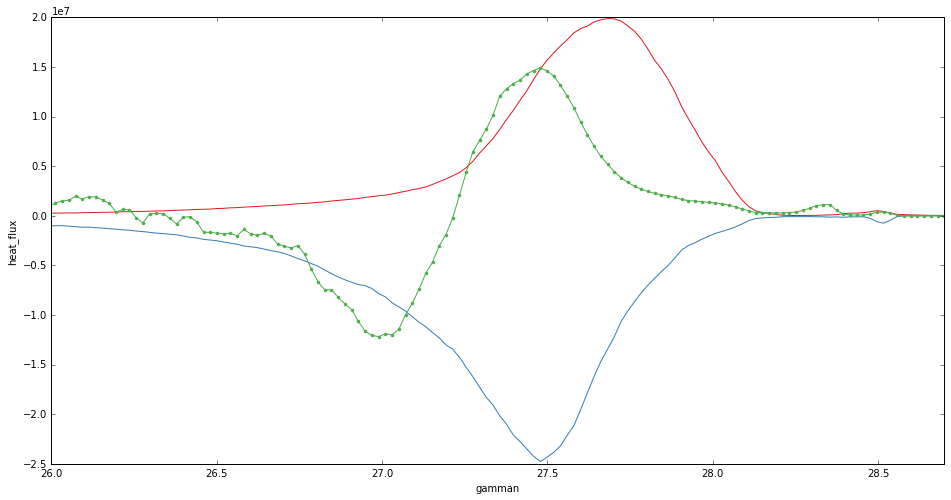

In [27]:
ds.salt_IO_brine.mean(dim='time').plot()
ds.salt_IO_melt.mean(dim='time').plot()
ds.heat_flux.mean(dim='time').plot(marker='.')
plt.xlim([26, 28.7])

In [56]:
ds_fw = xray.Dataset(coords={'gamman': gamman, 'time': time})

for n in range(len(fw_flux_types)):
    ds_fw[fw_flux_types[n]] = xray.DataArray(fw_in_dens_coords[:,n],
                        coords=[time, gamman], dims=('time', 'gamman'))

ds_fw['drho'] = xray.DataArray(drho, coords=[gamman], dims=['gamman'])
    
ds_fw.to_netcdf('../data/fw_flux_gamman.nc')

In [54]:
ds_ice = xray.Dataset(coords={'gamman': gamman, 'time': time})
ds_ice['heff'] = xray.DataArray(heff_rho, 
                   coords=[time, gamman], dims=('time', 'gamman'))
ds_ice['concentration'] = xray.DataArray(ice_conc_rho, 
                   coords=[time, gamman], dims=('time', 'gamman'))
ds_ice['outcrop_area'] = xray.DataArray(outcrop_area, 
                   coords=[time, gamman], dims=('time', 'gamman'))
ds_ice.to_netcdf('../data/ice_in_gamman.nc')
ds_ice

<xray.Dataset>
Dimensions:        (gamman: 329, time: 438)
Coordinates:
  * gamman         (gamman) float64 22.02 22.04 22.06 22.08 22.1 22.12 22.14 ...
  * time           (time) datetime64[ns] 2005-01-06T05:00:00 ...
Data variables:
    heff           (time, gamman) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    concentration  (time, gamman) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    outcrop_area   (time, gamman) float64 0.0 0.0 0.0 4.544e+08 2.716e+08 ...

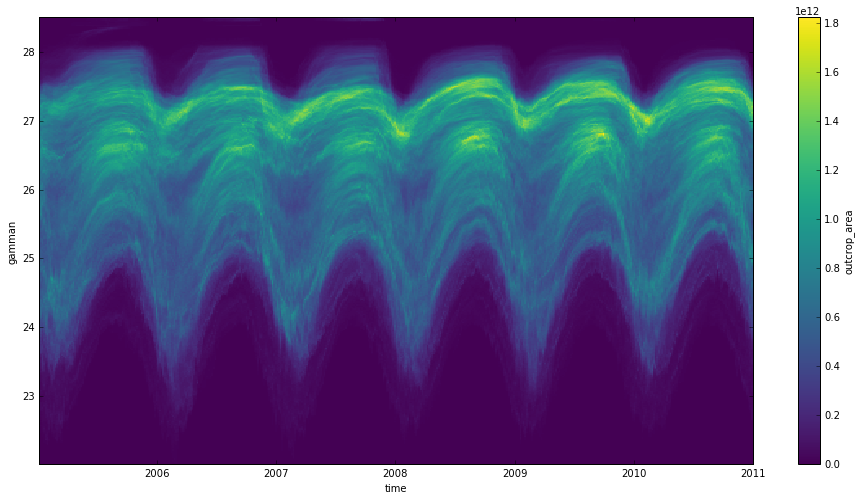

In [59]:
ds_ice.outcrop_area.T.plot()